In [14]:
import OOPAO
import tomoAO


import matplotlib.pyplot as plt
import numpy as np

import matplotlib

from scipy.io import savemat, loadmat



In [15]:
ao_mode = "MLAO"

config_dir = "./"
config_file = "config_keck.ini"

config_vars = tomoAO.IO.load_from_ini(config_file, ao_mode=ao_mode,config_dir=config_dir)


In [16]:
from OOPAO.Source import Source
from OOPAO.Asterism import Asterism

optBand = config_vars["lgs_opticalBand"]
magnitude = config_vars["lgs_magnitude"]
lgs_zenith = config_vars["lgs_zenith"]
lgs_azimuth = config_vars["lgs_azimuth"]
lgs_altitude = config_vars["lgs_altitude"]

n_lgs = 1

fwhm_spot = 0.5 # arcsec

# Na Profile
n = 11 # sampling of the Na Profile
Na_profile = np.zeros([2,n])
Na_profile[0,:] = np.linspace(80000,100000,n) # altitude in m of the Na layer
Na_profile[1,:] = 1/n # Na density profile, here considered to be uniform

theta = np.linspace(0,360, n_lgs,endpoint=False) #deg

zenith = config_vars["lgs_zenith"][0]

lgsAst = Asterism([Source(optBand=optBand,
                  magnitude=magnitude,
                  laser_coordinates=[np.cos(np.deg2rad(i_theta))*13.5/2,np.sin(np.deg2rad(i_theta))*13.5/2], 
                  Na_profile=Na_profile,
                  FWHM_spot_up= fwhm_spot,
                  coordinates = [zenith,i_theta])
                  for i_theta in theta])



-------------- Source --------------
Source                   |   LGS   
Wavelength [m]           | 5.9e-07 
Zenith [arcsec]          |  7.60   
Azimuth [°]              |  0.00   
Altitude [m]             |90000.00 
Magnitude                |  8.89   
Flux [photon/m²/s]       | 2.5e+06 
Coordinates [arcsec,deg] | [7.6,0.0]
------------------------------------


--------------------------------- Asterism ---------------------------------
 Source | Wavelength | Zenith | Azimuth | Altitude | Magnitude |   Flux    |
        |    [m]     |[arcsec]|   [°]   |   [m]    |           | [ph/m²/s] |
  1-LGS |  5.9e-07   |  7.60  |  0.00   | 90000.00 |   8.89    |  2.5e+06  |
----------------------------------------------------------------------------




------------ Telescope -------------
Diameter [m]             |  13.50   
Resolution [px]          |   288    
Pixel size [m]           |   0.05   
Surface [m²]             |   0.05   
Central obstruction [%]  |    24    
Pixels in pupil          |  61552   
Field of view [arcsec]   |  15.00   
------------------------------------

OOPAO Warning: 
A new pupil is now considered, its reflectivity is considered to be uniform. Assign the proper reflectivity map to tel.pupilReflectivity if required.


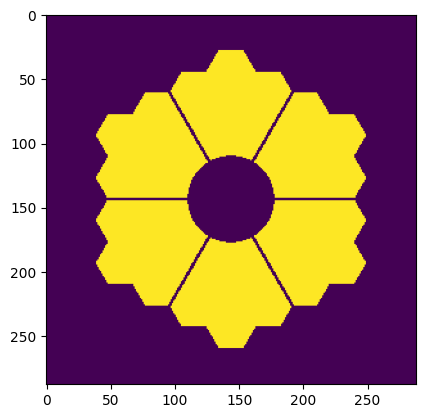

In [17]:
from OOPAO.Telescope import Telescope


sensing_wavelength  = lgsAst.src[0].wavelength           # sensing wavelength of the WFS, read from the ngs object
n_subaperture       = config_vars["nSubaperture"]        # number of subaperture across the diameter
diameter            = config_vars["diameter"]            # diameter of the support of the phase screens in [m]
resolution          = config_vars["resolution"]          # resolution of the phase screens in pixels
obs_ratio           = config_vars["centralObstruction"]  # central obstruction in fraction of the telescope diameter
sampling_time       = config_vars["samplingTime"]        # sampling time of the AO loop in [s]
fieldOfViewInArcsec = config_vars["fieldOfViewInArcsec"] # field of view of the telescope (arcsec)


tel = Telescope(diameter          = diameter,
               resolution         = resolution,
               centralObstruction = obs_ratio,
               samplingTime       = sampling_time,
               fov                = fieldOfViewInArcsec)


pupil_data = loadmat(config_vars["tel_pupil"])
pupil = pupil_data['pup'] 

tel.pupil = pupil

plt.imshow(tel.pupil)

In [5]:
from OOPAO.Atmosphere import Atmosphere

r0 = 0.16
L0 = 50

fractionnalR0 = [1]
windSpeed = [5.0]
windDirection = [0]
altitude = [10000]

atm = Atmosphere(telescope      = tel,
                 src            = lgsAst,
                 r0             = r0,
                 L0             = L0,
                 fractionalR0   = fractionnalR0,
                 altitude       = altitude,
                 windDirection  = windDirection,
                 windSpeed      = windSpeed)


atm.initializeAtmosphere(telescope=tel)

Creation of layer1/1 ...
-> Computing the initial phase screen...
initial phase screen : 0.03028559684753418 s
ZZt.. : 8.047802209854126 s
ZXt.. : 1.5390186309814453 s
XXt.. : 0.6879491806030273 s
Done!
Updating the Atmosphere covariance matrices...

------------------------ Atmosphere -------------------------
 Layer | Direction | Speed | Altitude | Frac Cn² | Diameter |
       |    [°]    | [m/s] |   [m]    |   [%]    |   [m]    |
   1   |     0     |  5.0  |  1e+04   |   100    |  14.438  |
r0 @ 500 nm [m] |   0.16   
L0 [m]          |   50.0   
Tau0 [s]        |  0.0099  
V0 [m/s]        |   5.00   
Frequency [Hz]  |  200.0   
-------------------------------------------------------------



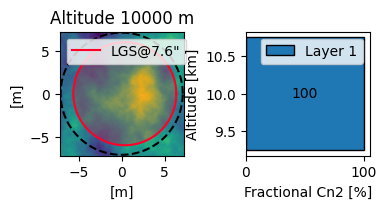

In [6]:
lgsAst**atm*tel
atm.display_atm_layers()


In [7]:
from OOPAO.ShackHartmann import ShackHartmann


unfiltered_subap_mask = np.loadtxt(config_vars["unfiltered_subap_mask"], dtype=bool, delimiter=",")
filtered_subap_mask = np.loadtxt(config_vars["filtered_subap_mask"], dtype=bool, delimiter=",")

shwfs_unfiltered = ShackHartmann(telescope          = tel,
                      nSubap             = n_subaperture,
                      lightRatio         = 0.1,
                      is_geometric       = False,
                      shannon_sampling   = True,
                      threshold_cog      = 0.01)


shwfs_unfiltered.valid_subapertures = unfiltered_subap_mask.copy()

shwfs_filtered = ShackHartmann(telescope          = tel,
                      nSubap             = n_subaperture,
                      lightRatio         = 0.1,
                      is_geometric       = False,
                      shannon_sampling   = True,
                      threshold_cog      = 0.01)


shwfs_filtered.valid_subapertures = filtered_subap_mask.copy()




No user-input pixel scale - using shannon_sampling input value:2 pixel(s) per spot FWHM
-------------Detector--------------
Sensor type              |   CCD   
Resolution [px]          |   288   
Gain                     |    1    
Quantum efficiency [%]   |   100   
Binning                  |   1x1   
Dark current [e-/px/s]   |  0.00   
Photon noise             |  False  
Bkg noise [e-]           |  False  
Readout noise [e-/px]    |   0.0   
-----------------------------------

Selecting valid subapertures based on flux considerations..
Acquiring reference slopes..
updating the flux of the SHWFS object
Done!
Recalibrating the slopes units
Acquiring reference slopes..
Done!
Done

------- Shack-Hartmann WFS --------
Subapertures [lenslets]  |   24    
Subaperture Pitch [m]    |  0.56   
Subaperture FoV [arcsec] |  1.30   
Pixel Scale [arcsec]     |  0.108  
Valid Subapertures       |   504   
Spot Sampling [pix]      |  4.630  
Max Elongation [arcsec]  |  7.736  
Geometric WFS         

/home/joaomonteiro/Desktop/OOPAO-spaceodt/OOPAO/OOPAO/ShackHartmann.py:525: RuntimeWarning: invalid value encountered in divide
  centroid_out[:, 0] = np.sum(np.sum(im*X_coord_map, axis=1), axis=1)/norma
/home/joaomonteiro/Desktop/OOPAO-spaceodt/OOPAO/OOPAO/ShackHartmann.py:526: RuntimeWarning: invalid value encountered in divide
  centroid_out[:, 1] = np.sum(np.sum(im*Y_coord_map, axis=1), axis=1)/norma


OOPAO Warning: 
Some subapertures are giving nan values!
Done

------- Shack-Hartmann WFS --------
Subapertures [lenslets]  |   24    
Subaperture Pitch [m]    |  0.56   
Subaperture FoV [arcsec] |  1.30   
Pixel Scale [arcsec]     |  0.108  
Valid Subapertures       |   608   
Spot Sampling [pix]      |  4.630  
Max Elongation [arcsec]  |  7.736  
Geometric WFS            |  False  
-----------------------------------

No user-input pixel scale - using shannon_sampling input value:2 pixel(s) per spot FWHM
-------------Detector--------------
Sensor type              |   CCD   
Resolution [px]          |   288   
Gain                     |    1    
Quantum efficiency [%]   |   100   
Binning                  |   1x1   
Dark current [e-/px/s]   |  0.00   
Photon noise             |  False  
Bkg noise [e-]           |  False  
Readout noise [e-/px]    |   0.0   
-----------------------------------

Selecting valid subapertures based on flux considerations..
Acquiring reference slopes..
Do

In [8]:
from OOPAO.DeformableMirror import DeformableMirror
from OOPAO.MisRegistration import MisRegistration


mechanical_coupling = config_vars['mechanicalCoupling']
misReg = MisRegistration(config_vars)

unfiltered_act_mask = np.loadtxt(config_vars["actuator_mask"], dtype=bool, delimiter=",")
if unfiltered_act_mask.shape[0] != config_vars['nActuator']:
    unfiltered_act_mask = np.pad(unfiltered_act_mask, pad_width=int(config_vars['nSubapExtra']/2), mode='constant', constant_values=0)


X, Y = tomoAO.tools.tomography_tools.meshgrid(config_vars['nActuator'], tel.D, offset_x=0.0, offset_y=0.0, stretch_x=1, stretch_y=1)
coordinates = np.array([X[unfiltered_act_mask], Y[unfiltered_act_mask]]).T

dm = DeformableMirror(telescope=tel,
                            nSubap=config_vars['nSubaperture'],
                            mechCoupling=config_vars['mechanicalCoupling'],
                            misReg=misReg,
                            coordinates=coordinates,
                            pitch=tel.D / (config_vars['nActuator'] - 1))


dm.unfiltered_act_mask = unfiltered_act_mask.copy()


Coordinates loaded...
Generating a Deformable Mirror: 
Computing the 2D zonal modes...

-------- Deformable mirror --------
Controlled Actuators     |   349   
M4                       |  False  
Pitch [m]                |  0.56   
Mechnical coupling [%]   |   15    
== Misregistration ================
Rotation [°]             |  0.000  
Shift X [m]              |0.000e+00
Shift Y [m]              |0.000e+00
Anamorphosis angle [°]   |  0.000  
Tangential scaling [%]   |  0.000  
Radial scaling [%]       |  0.000  
-----------------------------------



In [9]:
aoSys = tomoAO.Simulation.AOSystem(config_vars, 
                                   tel=tel, 
                                   lgsAst=lgsAst, 
                                   dm=dm, atm=atm, 
                                   wfs=shwfs_unfiltered,
                                   unfiltered_subap_mask=unfiltered_subap_mask,
                                   filtered_subap_mask=filtered_subap_mask)

from tomoAO.Reconstruction.reconClassType import tomoReconstructor

rec = tomoReconstructor(aoSys=aoSys, alpha=10, os=2, 
                        order=config_vars["order"], indexation=config_vars["indexation"],
                        remove_TT_F = False)

reconstructor = rec.reconstructor.copy()

atm.r0 = 0.16



------------- Source --------------
Source                   |   NGS   
Wavelength [m]           | 5.9e-07 
Zenith [arcsec]          |  0.00   
Azimuth [°]              |  0.00   
Altitude [m]             |   inf   
Magnitude                |  0.00   
Flux [photon/m²/s]       | 9.0e+09 
Coordinates [arcsec,deg] | [0,0]
-----------------------------------


------------- Source --------------
Source                   |   NGS   
Wavelength [m]           | 2.2e-06 
Zenith [arcsec]          |  0.00   
Azimuth [°]              |  0.00   
Altitude [m]             |   inf   
Magnitude                |  0.00   
Flux [photon/m²/s]       | 1.9e+09 
Coordinates [arcsec,deg] | [0,0]
-----------------------------------

Coordinates loaded...
Generating a Deformable Mirror: 
Computing the 2D zonal modes...

-------- Deformable mirror --------
Controlled Actuators     |   349   
M4                       |  False  
Pitch [m]                |  0.56   
Mechnical coupling [%]   |   15    
== Misregistra

In [10]:
from OOPAO.calibration.compute_KL_modal_basis import compute_KL_basis
M2C_KL = compute_KL_basis(src=lgsAst.src[0],tel=tel,atm=atm,dm=dm)

TIME ELAPSED: 7 sec. COMPLETED: 100 %
NMAX =  293
RMS opd error = [[1.17636685e-08 1.18926392e-08 1.20774297e-08]]
RMS Positions = [[2.12866083e-07 6.19696799e-07 6.19859451e-07]]
MAX Positions = [[6.89768017e-07 1.46852240e-06 1.33504757e-06]]
KL WITH DOUBLE DIAGONALISATION: COVARIANCE ERROR =  6.86202618064504e-14


OOPAO Warning: 
Some subapertures are giving nan values!


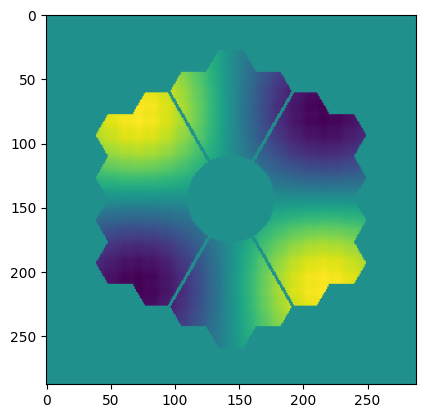

In [19]:
mode = 3

input_modes = 1e-9

dm.coefs = M2C_KL[:,mode] * input_modes

lgsAst**tel*dm*shwfs_unfiltered*shwfs_filtered


plt.imshow(lgsAst.OPD[0])

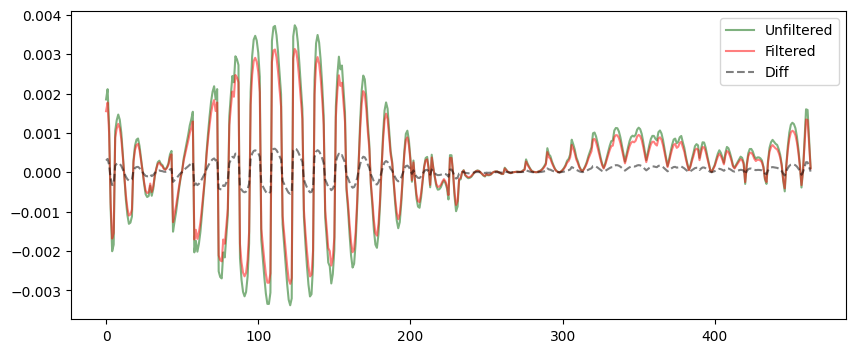

In [20]:
unfiltered_signal = rec.filtering_matrix@rec.signal_permutation_matrix@np.hstack(shwfs_unfiltered.signal)


signal_permutation_matrix = tomoAO.tools.tomography_tools.get_signal_permutation_matrix(filtered_subap_mask, rec.nGuideStar)
filtered_signal = signal_permutation_matrix@np.hstack(shwfs_filtered.signal)


fig, axes = plt.subplots(1, 1, figsize=(10, 4))

axes.plot(unfiltered_signal, label = "Unfiltered", 
          color="darkgreen", alpha=0.5)


axes.plot(filtered_signal, label = "Filtered",
           color="red", alpha=0.5)

axes.plot(unfiltered_signal-filtered_signal, 
          label = "Diff", linestyle="--", color="black", alpha=0.5)
axes.legend()

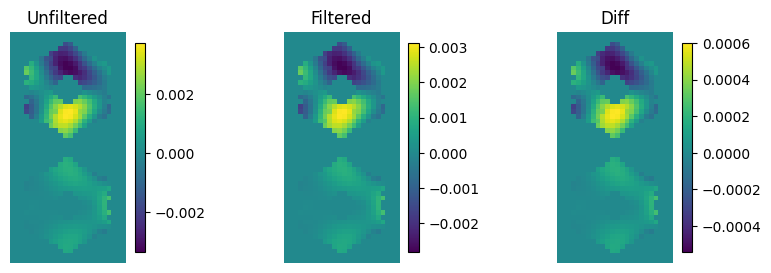

In [ ]:
unfiltered_signal_2D = shwfs_unfiltered.signal_2D[0].copy()*shwfs_filtered.valid_slopes_maps
unfiltered_signal_2D = unfiltered_signal_2D

filtered_signal_2D = shwfs_filtered.signal_2D[0].copy()

fig, axes = plt.subplots(1, 3, figsize=(10, 3))

im = axes[0].imshow(unfiltered_signal_2D)
axes[0].axis('off')
axes[0].set_title(f'Unfiltered')
fig.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)


im = axes[1].imshow(filtered_signal_2D)
axes[1].axis('off')
axes[1].set_title(f'Filtered')
fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)


im = axes[2].imshow(unfiltered_signal_2D-filtered_signal_2D)
axes[2].axis('off')
axes[2].set_title(f'Diff')
fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)


